# Predicting Wine Quality with Multi-Layer Perceptron (Regression)

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os

import kagglehub
from pathlib import Path
import importlib

### Custom models and optimizers

In [2]:
from models import Wine_MLP     # defined in models.py
from new_optimizers import MomentumSGD_Strong_Wolfe, Adam_Strong_Wolfe, TrustRegionCauchy, Levenberg_Marquardt   # defined in new_optimizers.py

### Downloading the dataset

In [3]:
# download latest version
path = kagglehub.dataset_download("yasserh/wine-quality-dataset")
data_dir = Path(path)
print(list(data_dir.iterdir()))  # see what files are there

[PosixPath('/home/mrz24/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1/WineQT.csv')]


### PyTorch data loading

In [9]:
# PyTorch Dataset for the Wine Quality dataset
class WineDataset(Dataset):
    def __init__(self, csv_file, target_col="quality"):
        df = pd.read_csv(csv_file)

        # features: all columns except the target
        X = df.drop(columns=[target_col]).values
        y = df[target_col].values

        # convert to tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [10]:
csv_path = data_dir / "WineQT.csv"
full_dataset = WineDataset(csv_path)

# simple train test split
num_samples = len(full_dataset)
num_train = int(0.8 * num_samples)
num_val = num_samples - num_train

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [num_train, num_val]
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)

### Writing train and test functions

In [11]:
criterion = nn.MSELoss()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.unsqueeze(1)
        
        def closure(backward=True, lm=False):
            if not lm:
                optimizer.zero_grad()
            output = model(data)
            if lm:
                residuals = output - target
                return residuals
            loss = criterion(output, target)
            if backward:
                loss.backward() # backward computes the gradients, stores them in the parameters, and deletes the computation graph
            return loss
        
        loss = closure()
        optimizer.step(closure)
        avg_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    return avg_loss / len(train_loader)

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.unsqueeze(1)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [12]:
# sets the seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # deterministic behavior in cuDNN
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

### Model training with the optimizers

In [33]:
epochs = 30

all_train_loss = []
all_val_loss = []

In [34]:
# Benchmark 1: SGD with Momentum
print("Benchmark 1: SGD with Momentum")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wine_MLP(input_size=12).to(device)
optimizer1 = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader, optimizer1, epoch)
    train_loss_over_epochs.append(avg_loss)
    val_loss = validate(model, device, val_loader)
    val_loss_over_epochs.append(val_loss)

all_train_loss.append(train_loss_over_epochs)
all_val_loss.append(val_loss_over_epochs)
print("Final Validation Loss (SGD with Momentum):", val_loss_over_epochs[-1])

Benchmark 1: SGD with Momentum
Train Epoch: 1 [0/914 (0%)]	Loss: 411.718658
Train Epoch: 1 [640/914 (67%)]	Loss: 27.849623
Train Epoch: 2 [0/914 (0%)]	Loss: 9.952955
Train Epoch: 2 [640/914 (67%)]	Loss: 9.231827
Train Epoch: 3 [0/914 (0%)]	Loss: 8.977101
Train Epoch: 3 [640/914 (67%)]	Loss: 9.428873
Train Epoch: 4 [0/914 (0%)]	Loss: 6.717239
Train Epoch: 4 [640/914 (67%)]	Loss: 6.590083
Train Epoch: 5 [0/914 (0%)]	Loss: 7.192152
Train Epoch: 5 [640/914 (67%)]	Loss: 7.728254
Train Epoch: 6 [0/914 (0%)]	Loss: 5.756029
Train Epoch: 6 [640/914 (67%)]	Loss: 8.878912
Train Epoch: 7 [0/914 (0%)]	Loss: 5.919411
Train Epoch: 7 [640/914 (67%)]	Loss: 7.085788
Train Epoch: 8 [0/914 (0%)]	Loss: 5.695599
Train Epoch: 8 [640/914 (67%)]	Loss: 6.250295
Train Epoch: 9 [0/914 (0%)]	Loss: 5.624289
Train Epoch: 9 [640/914 (67%)]	Loss: 6.915472
Train Epoch: 10 [0/914 (0%)]	Loss: 6.655528
Train Epoch: 10 [640/914 (67%)]	Loss: 6.261361
Train Epoch: 11 [0/914 (0%)]	Loss: 5.622010
Train Epoch: 11 [640/914 (67%)

In [35]:
# Benchmark 2: Adam
print("Benchmark 2: Adam")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wine_MLP(input_size=12).to(device)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader, optimizer2, epoch)
    train_loss_over_epochs.append(avg_loss)
    val_loss = validate(model, device, val_loader)
    val_loss_over_epochs.append(val_loss)

all_train_loss.append(train_loss_over_epochs)
all_val_loss.append(val_loss_over_epochs)
print("Final Validation Loss (Adam):", val_loss_over_epochs[-1])

Benchmark 2: Adam
Train Epoch: 1 [0/914 (0%)]	Loss: 411.718658
Train Epoch: 1 [640/914 (67%)]	Loss: 47.846855
Train Epoch: 2 [0/914 (0%)]	Loss: 4.977390
Train Epoch: 2 [640/914 (67%)]	Loss: 4.330237
Train Epoch: 3 [0/914 (0%)]	Loss: 5.663962
Train Epoch: 3 [640/914 (67%)]	Loss: 2.463397
Train Epoch: 4 [0/914 (0%)]	Loss: 1.840824
Train Epoch: 4 [640/914 (67%)]	Loss: 1.557693
Train Epoch: 5 [0/914 (0%)]	Loss: 2.072837
Train Epoch: 5 [640/914 (67%)]	Loss: 0.747194
Train Epoch: 6 [0/914 (0%)]	Loss: 0.785667
Train Epoch: 6 [640/914 (67%)]	Loss: 0.893250
Train Epoch: 7 [0/914 (0%)]	Loss: 0.803633
Train Epoch: 7 [640/914 (67%)]	Loss: 0.424383
Train Epoch: 8 [0/914 (0%)]	Loss: 0.850284
Train Epoch: 8 [640/914 (67%)]	Loss: 0.967428
Train Epoch: 9 [0/914 (0%)]	Loss: 0.937429
Train Epoch: 9 [640/914 (67%)]	Loss: 0.498672
Train Epoch: 10 [0/914 (0%)]	Loss: 1.721894
Train Epoch: 10 [640/914 (67%)]	Loss: 0.579088
Train Epoch: 11 [0/914 (0%)]	Loss: 0.508577
Train Epoch: 11 [640/914 (67%)]	Loss: 1.109

In [36]:
# New Optimizer 1: MomentumSGD_Strong_Wolfe
print("New Optimizer 1: MomentumSGD_Strong_Wolfe")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wine_MLP(input_size=12).to(device)
optimizer3 = MomentumSGD_Strong_Wolfe(model.parameters(), alpha1=1e-5, alpha_max=1e-2)

train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader, optimizer3, epoch)
    train_loss_over_epochs.append(avg_loss)
    val_loss = validate(model, device, val_loader)
    val_loss_over_epochs.append(val_loss)
all_train_loss.append(train_loss_over_epochs)
all_val_loss.append(val_loss_over_epochs)
print("Final Validation Loss (MomentumSGD_Strong_Wolfe):", val_loss_over_epochs[-1])

New Optimizer 1: MomentumSGD_Strong_Wolfe
Train Epoch: 1 [0/914 (0%)]	Loss: 411.718658
Train Epoch: 1 [640/914 (67%)]	Loss: 18.384380
Train Epoch: 2 [0/914 (0%)]	Loss: 11.100678
Train Epoch: 2 [640/914 (67%)]	Loss: 9.354997
Train Epoch: 3 [0/914 (0%)]	Loss: 10.118628
Train Epoch: 3 [640/914 (67%)]	Loss: 9.100363
Train Epoch: 4 [0/914 (0%)]	Loss: 5.872869
Train Epoch: 4 [640/914 (67%)]	Loss: 6.206580
Train Epoch: 5 [0/914 (0%)]	Loss: 7.096105
Train Epoch: 5 [640/914 (67%)]	Loss: 6.084145
Train Epoch: 6 [0/914 (0%)]	Loss: 5.535568
Train Epoch: 6 [640/914 (67%)]	Loss: 7.247958
Train Epoch: 7 [0/914 (0%)]	Loss: 6.626170
Train Epoch: 7 [640/914 (67%)]	Loss: 5.462184
Train Epoch: 8 [0/914 (0%)]	Loss: 5.237655
Train Epoch: 8 [640/914 (67%)]	Loss: 4.760875
Train Epoch: 9 [0/914 (0%)]	Loss: 4.182341
Train Epoch: 9 [640/914 (67%)]	Loss: 5.785385
Train Epoch: 10 [0/914 (0%)]	Loss: 5.713828
Train Epoch: 10 [640/914 (67%)]	Loss: 4.191668
Train Epoch: 11 [0/914 (0%)]	Loss: 3.125126
Train Epoch: 11 [

In [37]:
# New Optimizer 2: Adam_Strong_Wolfe
print("New Optimizer 2: Adam_Strong_Wolfe")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wine_MLP(input_size=12).to(device)
optimizer4 = Adam_Strong_Wolfe(model.parameters(), alpha1=1e-2, betas=(0.9, 0.999), alpha_max=10)

train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader, optimizer4, epoch)
    train_loss_over_epochs.append(avg_loss)
    val_loss = validate(model, device, val_loader)
    val_loss_over_epochs.append(val_loss)
all_train_loss.append(train_loss_over_epochs)
all_val_loss.append(val_loss_over_epochs)
print("Final Validation Loss (Adam_Strong_Wolfe):", val_loss_over_epochs[-1])

New Optimizer 2: Adam_Strong_Wolfe
Train Epoch: 1 [0/914 (0%)]	Loss: 411.718658
Train Epoch: 1 [640/914 (67%)]	Loss: 6.264558
Train Epoch: 2 [0/914 (0%)]	Loss: 4.354235
Train Epoch: 2 [640/914 (67%)]	Loss: 3.419778
Train Epoch: 3 [0/914 (0%)]	Loss: 2.406866
Train Epoch: 3 [640/914 (67%)]	Loss: 1.558822
Train Epoch: 4 [0/914 (0%)]	Loss: 1.107843
Train Epoch: 4 [640/914 (67%)]	Loss: 1.163944
Train Epoch: 5 [0/914 (0%)]	Loss: 0.771171
Train Epoch: 5 [640/914 (67%)]	Loss: 0.607723
Train Epoch: 6 [0/914 (0%)]	Loss: 0.702743
Train Epoch: 6 [640/914 (67%)]	Loss: 0.638231
Train Epoch: 7 [0/914 (0%)]	Loss: 0.838884
Train Epoch: 7 [640/914 (67%)]	Loss: 0.415869
Train Epoch: 8 [0/914 (0%)]	Loss: 0.723153
Train Epoch: 8 [640/914 (67%)]	Loss: 0.870191
Train Epoch: 9 [0/914 (0%)]	Loss: 0.612586
Train Epoch: 9 [640/914 (67%)]	Loss: 0.589924
Train Epoch: 10 [0/914 (0%)]	Loss: 0.503268
Train Epoch: 10 [640/914 (67%)]	Loss: 0.672311
Train Epoch: 11 [0/914 (0%)]	Loss: 0.545409
Train Epoch: 11 [640/914 (6

In [38]:
# New Optimizer 3: TrustRegionCauchy
print("New Optimizer 3: TrustRegionCauchy")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wine_MLP(input_size=12).to(device)
optimizer5 = TrustRegionCauchy(model.parameters(), r0=1e-2, rmax=1, eta=0.20)

train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader, optimizer5, epoch)
    train_loss_over_epochs.append(avg_loss)
    val_loss = validate(model, device, val_loader)
    val_loss_over_epochs.append(val_loss)
all_train_loss.append(train_loss_over_epochs)
all_val_loss.append(val_loss_over_epochs)
print("Final Validation Loss (TrustRegionCauchy):", val_loss_over_epochs[-1])


New Optimizer 3: TrustRegionCauchy
Train Epoch: 1 [0/914 (0%)]	Loss: 411.718658
Train Epoch: 1 [640/914 (67%)]	Loss: 14.665897
Train Epoch: 2 [0/914 (0%)]	Loss: 11.892742
Train Epoch: 2 [640/914 (67%)]	Loss: 12.917377
Train Epoch: 3 [0/914 (0%)]	Loss: 12.091741
Train Epoch: 3 [640/914 (67%)]	Loss: 14.956493
Train Epoch: 4 [0/914 (0%)]	Loss: 10.201019
Train Epoch: 4 [640/914 (67%)]	Loss: 8.971050
Train Epoch: 5 [0/914 (0%)]	Loss: 11.740614
Train Epoch: 5 [640/914 (67%)]	Loss: 9.548082
Train Epoch: 6 [0/914 (0%)]	Loss: 7.104159
Train Epoch: 6 [640/914 (67%)]	Loss: 10.789033
Train Epoch: 7 [0/914 (0%)]	Loss: 7.496434
Train Epoch: 7 [640/914 (67%)]	Loss: 7.763832
Train Epoch: 8 [0/914 (0%)]	Loss: 5.939502
Train Epoch: 8 [640/914 (67%)]	Loss: 5.799175
Train Epoch: 9 [0/914 (0%)]	Loss: 4.938680
Train Epoch: 9 [640/914 (67%)]	Loss: 7.391136
Train Epoch: 10 [0/914 (0%)]	Loss: 6.441891
Train Epoch: 10 [640/914 (67%)]	Loss: 5.982890
Train Epoch: 11 [0/914 (0%)]	Loss: 5.698633
Train Epoch: 11 [64

In [39]:
# New Optimizer 4: Levenberg_Marquardt
print("New Optimizer 4: Levenberg_Marquardt")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wine_MLP(input_size=12).to(device)
optimizer6 = Levenberg_Marquardt(model.parameters(), lambda_=1, lw_iter=40)

train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader, optimizer6, epoch)
    train_loss_over_epochs.append(avg_loss)
    val_loss = validate(model, device, val_loader)
    val_loss_over_epochs.append(val_loss)
all_train_loss.append(train_loss_over_epochs)
all_val_loss.append(val_loss_over_epochs)
print("Final Validation Loss (Levenberg_Marquardt):", val_loss_over_epochs[-1])

New Optimizer 4: Levenberg_Marquardt
Train Epoch: 1 [0/914 (0%)]	Loss: 411.718658
Train Epoch: 1 [640/914 (67%)]	Loss: 9.924375
Train Epoch: 2 [0/914 (0%)]	Loss: 6.540414
Train Epoch: 2 [640/914 (67%)]	Loss: 6.456035
Train Epoch: 3 [0/914 (0%)]	Loss: 4.848451
Train Epoch: 3 [640/914 (67%)]	Loss: 5.052877
Train Epoch: 4 [0/914 (0%)]	Loss: 6.305172
Train Epoch: 4 [640/914 (67%)]	Loss: 4.783191
Train Epoch: 5 [0/914 (0%)]	Loss: 4.511718
Train Epoch: 5 [640/914 (67%)]	Loss: 4.241092
Train Epoch: 6 [0/914 (0%)]	Loss: 5.097271
Train Epoch: 6 [640/914 (67%)]	Loss: 3.480271
Train Epoch: 7 [0/914 (0%)]	Loss: 4.375631
Train Epoch: 7 [640/914 (67%)]	Loss: 4.170261
Train Epoch: 8 [0/914 (0%)]	Loss: 3.977858
Train Epoch: 8 [640/914 (67%)]	Loss: 4.092279
Train Epoch: 9 [0/914 (0%)]	Loss: 4.180991
Train Epoch: 9 [640/914 (67%)]	Loss: 3.688637
Train Epoch: 10 [0/914 (0%)]	Loss: 4.236483
Train Epoch: 10 [640/914 (67%)]	Loss: 4.429037
Train Epoch: 11 [0/914 (0%)]	Loss: 3.292206
Train Epoch: 11 [640/914 

In [40]:
# save results to csv
os.makedirs("WineQ_results", exist_ok=True)
pd.DataFrame(all_train_loss).to_csv('WineQ_results/train_loss.csv', index=False)
pd.DataFrame(all_val_loss).to_csv('WineQ_results/test_loss.csv', index=False)

In [ ]:
# load results if already saved
# all_train_loss = pd.read_csv('WineQ_results/train_loss.csv').values
# all_test_loss = pd.read_csv('WineQ_results/test_loss.csv').values

### Plotting results

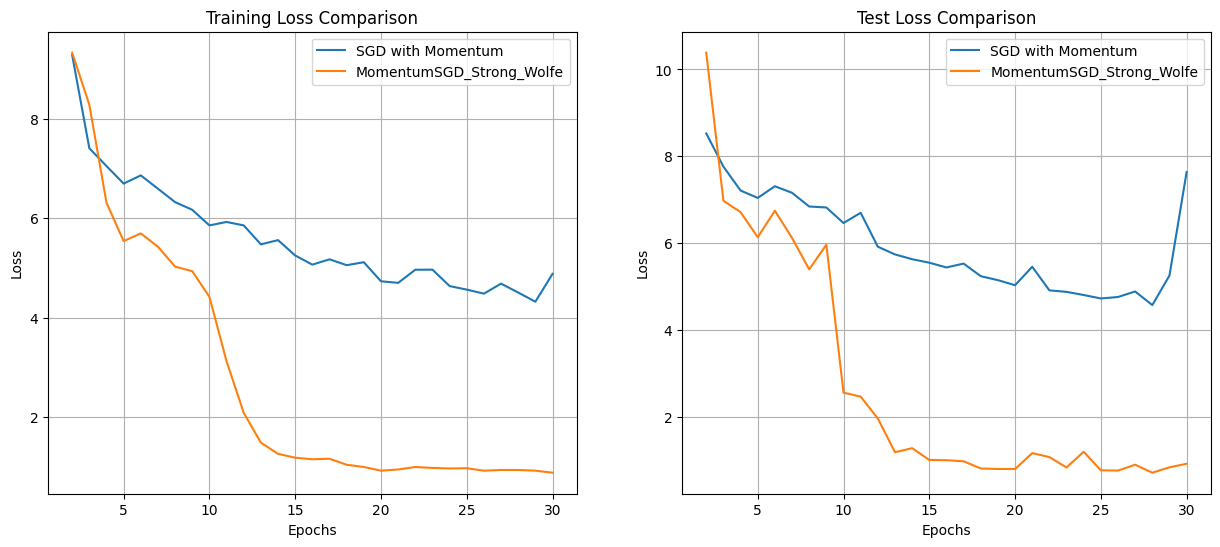

In [41]:
# Plotting MomentumSGD vs MomentumSGD_Strong_Wolfe
plt.figure(figsize=(15, 6))
x = range(2, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(x, all_train_loss[0][1:], label='SGD with Momentum')
plt.plot(x, all_train_loss[2][1:], label='MomentumSGD_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, all_val_loss[0][1:], label='SGD with Momentum')
plt.plot(x, all_val_loss[2][1:], label='MomentumSGD_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')
plt.legend()
plt.grid()

plt.show()

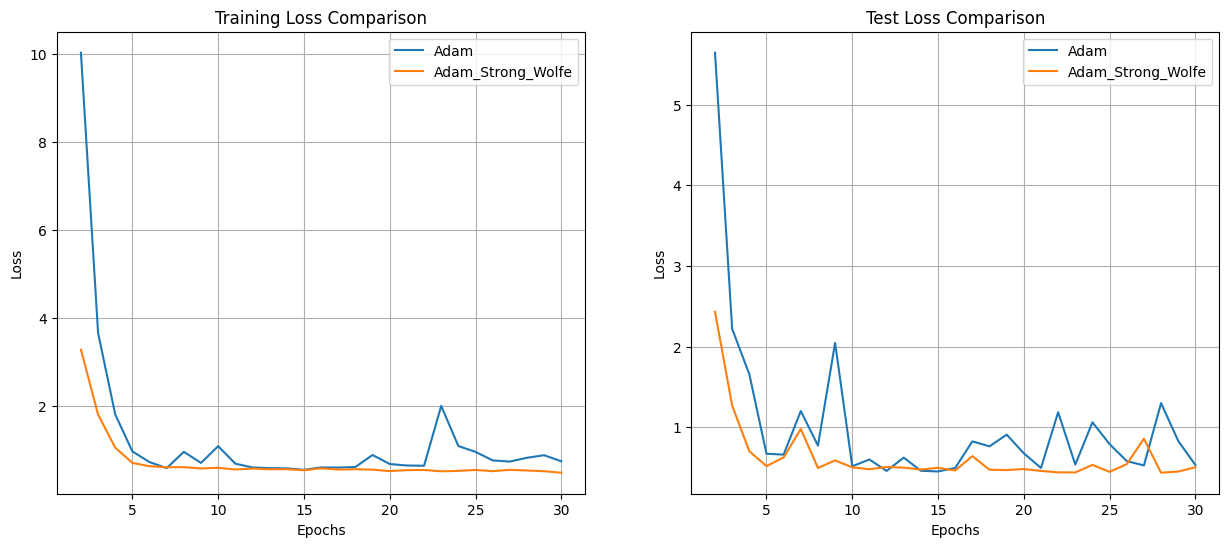

In [42]:
# Plotting Adam vs Adam_Strong_Wolfe
plt.figure(figsize=(15, 6))
x = range(2, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(x, all_train_loss[1][1:], label='Adam')
plt.plot(x, all_train_loss[3][1:], label='Adam_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, all_val_loss[1][1:], label='Adam')
plt.plot(x, all_val_loss[3][1:], label='Adam_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')
plt.legend()
plt.grid()

plt.show()

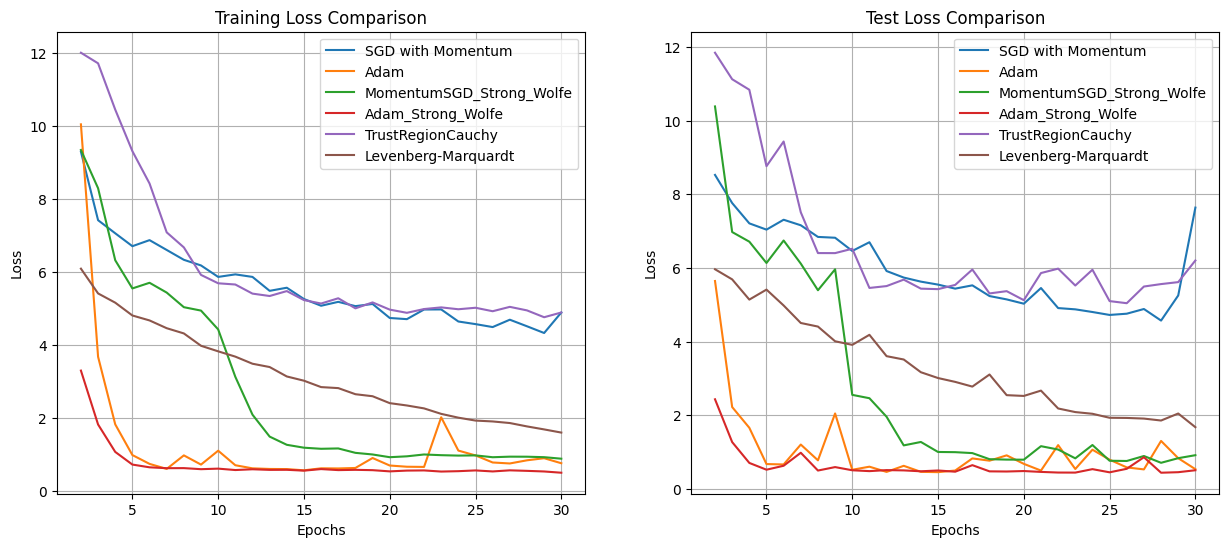

In [43]:
# Plotting all train loss and test accuracy
plt.figure(figsize=(15, 6))
x = range(2, epochs + 1)
plt.subplot(1, 2, 1)
for i, label in enumerate(['SGD with Momentum', 'Adam', 'MomentumSGD_Strong_Wolfe', 'Adam_Strong_Wolfe', 'TrustRegionCauchy', 'Levenberg-Marquardt']):
    plt.plot(x, all_train_loss[i][1:], label=f'{label}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for i, label in enumerate(['SGD with Momentum', 'Adam', 'MomentumSGD_Strong_Wolfe', 'Adam_Strong_Wolfe', 'TrustRegionCauchy', 'Levenberg-Marquardt']):
    plt.plot(x, all_val_loss[i][1:], label=f'{label}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')
plt.legend()
plt.grid()

plt.show()